%load_ext autoreload
%autoreload 2
https://blog.csdn.net/m0_46413065/article/details/129917287

In [96]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [97]:
data_g2 = pd.read_csv("./Data/Kaohsiung/g2.csv",delimiter=';')
data_g3 = pd.read_csv("./Data/Kaohsiung/g3.csv",delimiter=';')
data_g4 = pd.read_csv("./Data/Kaohsiung/g4.csv",delimiter=';')
data = [data_g2]

features = ['date_time']
targets = ['EMove', 'NMove', 'HMove']
group_id_i = 2

for i in range(1):
    data[i]['date_time'] = pd.to_datetime(data[i]['date_time'])
    data[i]['date_time'] = data[i]['date_time'].astype(int) / (10 ** 11)
    data[i]['date_time'] = data[i]['date_time'].astype(int)
    data[i] = data[i][features+targets]
    #data[i]['group_id'] = group_id_i
    group_id_i += 1
    
data = pd.concat(data,ignore_index=True)
data['group_id'] = 0

In [98]:
# Remove values outside 3 standard deviations

for col in targets:
    mean = data[col].mean()
    std = data[col].std()
    data = data[(data[col] >= mean - 3*std) & (data[col] <= mean + 3*std)]

In [99]:
data.head()

,date_time,EMove,NMove,HMove,group_id
0,17055522,0.0,0.0,0.0,0
1,17055528,-1.1,1.0,-0.5,0
2,17055744,-1.8,1.0,-18.6,0
3,17055750,1.0,-7.2,-30.2,0
4,17055762,2.0,-5.9,-20.6,0


In [100]:
data.tail()

,date_time,EMove,NMove,HMove,group_id
31124,17354172,-64.5,-546.1,66.4,0
31125,17354178,-64.0,-545.5,67.6,0
31126,17354184,-62.8,-545.3,71.5,0
31127,17354190,-62.0,-544.6,72.0,0
31128,17354196,-61.5,-543.2,72.6,0


In [101]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import MultiNormalizer,TorchNormalizer

max_prediction_length = 14
max_encoder_length = 7*14

training = TimeSeriesDataSet(
    data[:int(len(data)*0.8)],
    group_ids = ["group_id"],
    target = targets,
    time_idx = "date_time",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=max_encoder_length//2,  # 似乎要自己設置(默認值好像太大?)
    min_prediction_length=1,  #同上
    time_varying_unknown_reals = targets,
    target_normalizer=MultiNormalizer([TorchNormalizer() for _ in targets]),
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training,data,predict=True,stop_randomization=True)

batch_size = 32

train_dataloader = training.to_dataloader(train=True,batch_size=batch_size,num_workers=4)
val_dataloader = validation.to_dataloader(train=False,batch_size=batch_size*10,num_workers=4)

In [102]:
# from pytorch_forecasting import Baseline

# actuals = torch.cat([y[0] for x, (y,weight) in iter(val_dataloader)])
# baseline_predictions = Baseline().predict(val_dataloader)
# # 假設你希望將 `baseline_predictions` 移動到相同的設備
# baseline_predictions = baseline_predictions.to(actuals.device)

# # 現在兩者在相同設備上，可以進行計算
# result = (actuals - baseline_predictions).abs().mean().item()

from pytorch_forecasting import Baseline

# 取得 `actuals`，支援多個 target
actuals = torch.cat([y if isinstance(y, torch.Tensor) else y[0] for x, (y, weight) in iter(val_dataloader)])

# 獲取 baseline 預測值
baseline_predictions = Baseline().predict(val_dataloader)

# 確保 `baseline_predictions` 是 tensor
if isinstance(baseline_predictions, list):
    baseline_predictions = torch.stack(baseline_predictions, dim=1)  # 確保維度對應

# 確保 baseline_predictions 在相同設備
baseline_predictions = baseline_predictions.to(actuals.device)

# 計算 MAE
result = (actuals - baseline_predictions).abs().mean(dim=[0, 2])  # 針對每個 target 計算 MAE
print("MAE for each target:", result.tolist())


/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 

MAE for each target: [1.5500003099441528, 483.050048828125, 130.0500030517578]


In [103]:
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss, MultiLoss

early_stop_callback = EarlyStopping(monitor="val_loss",min_delta=1e-4,patience=5,verbose=True,mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=15,
    accelerator = 'gpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    accumulate_grad_batches=4,
    callbacks=[lr_logger,early_stop_callback],
    logger=logger
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.005,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.3,
    hidden_continuous_size=32,
    optimizer="adam",
    output_size=[1,1,1], #len(targets),
    loss=MultiLoss([QuantileLoss(quantiles=[0.5]),QuantileLoss(quantiles=[0.5]),QuantileLoss(quantiles=[0.5])]),
    log_interval=10,
    reduce_on_plateau_patience=2
)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 6.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 20.7 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_co

Epoch 0: 100%|██████████| 832/832 [00:13<00:00, 60.73it/s, v_num=24, train_loss_step=19.90, val_loss=472.0, train_loss_epoch=24.50]

Metric val_loss improved. New best score: 471.827


Epoch 1: 100%|██████████| 832/832 [00:13<00:00, 59.61it/s, v_num=24, train_loss_step=14.30, val_loss=454.0, train_loss_epoch=15.60]

Metric val_loss improved by 18.281 >= min_delta = 0.0001. New best score: 453.545


Epoch 2: 100%|██████████| 832/832 [00:13<00:00, 59.77it/s, v_num=24, train_loss_step=15.10, val_loss=450.0, train_loss_epoch=13.20]

Metric val_loss improved by 3.538 >= min_delta = 0.0001. New best score: 450.007


Epoch 3: 100%|██████████| 832/832 [00:14<00:00, 56.51it/s, v_num=24, train_loss_step=9.410, val_loss=442.0, train_loss_epoch=12.50]

Metric val_loss improved by 8.158 >= min_delta = 0.0001. New best score: 441.850


Epoch 4: 100%|██████████| 832/832 [00:13<00:00, 59.98it/s, v_num=24, train_loss_step=9.960, val_loss=423.0, train_loss_epoch=11.50]

Metric val_loss improved by 19.218 >= min_delta = 0.0001. New best score: 422.632


Epoch 6: 100%|██████████| 832/832 [00:13<00:00, 59.60it/s, v_num=24, train_loss_step=13.30, val_loss=417.0, train_loss_epoch=10.30]

Metric val_loss improved by 5.395 >= min_delta = 0.0001. New best score: 417.237


Epoch 8: 100%|██████████| 832/832 [00:13<00:00, 59.55it/s, v_num=24, train_loss_step=6.530, val_loss=409.0, train_loss_epoch=9.430]

Metric val_loss improved by 8.003 >= min_delta = 0.0001. New best score: 409.234


Epoch 13: 100%|██████████| 832/832 [00:13<00:00, 59.62it/s, v_num=24, train_loss_step=12.50, val_loss=411.0, train_loss_epoch=8.410]

Monitored metric val_loss did not improve in the last 5 records. Best score: 409.234. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 832/832 [00:14<00:00, 58.45it/s, v_num=24, train_loss_step=12.50, val_loss=411.0, train_loss_epoch=8.410]


In [104]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_24/checkpoints/epoch=13-step=2912.ckpt


/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [105]:
for x, (y, weight) in iter(val_dataloader):
    print(f"Type of y: {type(y)}")
    print(f"Example of y: {y}")
    break  # Just checking one batch

Type of y: <class 'list'>
Example of y: [tensor([[-64.0000, -62.8000, -62.8000, -62.8000, -62.8000, -62.8000, -62.8000,
         -62.0000, -62.0000, -62.0000, -62.0000, -62.0000, -62.0000, -61.5000]]), tensor([[-545.5000, -545.3000, -545.3000, -545.3000, -545.3000, -545.3000,
         -545.3000, -544.6000, -544.6000, -544.6000, -544.6000, -544.6000,
         -544.6000, -543.2000]]), tensor([[67.6000, 71.5000, 71.5000, 71.5000, 71.5000, 71.5000, 71.5000, 72.0000,
         72.0000, 72.0000, 72.0000, 72.0000, 72.0000, 72.6000]])]


In [106]:

#actuals = torch.cat([y for x,y in iter(val_dataloader)]).cpu().numpy()
#actuals = torch.cat([torch.tensor(y) if isinstance(y, list) else y for x, (y, weight) in iter(val_dataloader)])
actuals = torch.cat([t for t in y], dim=0)

predictions = best_tft.predict(val_dataloader)
predictions = torch.stack(predictions)  # This assumes each element in predictions is a tensor of shape (num_samples, 1)
predictions = predictions.squeeze(1)  # Remove the dimension of size 1, leaving shape (3, 7)
print(f"actuals shape: {actuals.shape}")
print(f"predictions shape: {predictions.shape}")

from sklearn.metrics import mean_absolute_error, mean_squared_error 

#mae_T = mean_absolute_error(actuals, predictions)
#rmse_T = np.sqrt(mean_squared_error(actuals, predictions))

#print(mae_T,'\n',rmse_T)

# 对于每个目标，计算 MAE 和 RMSE
for target_idx in range(3):  # 假设 actuals 和 predictions 的形状是 (num_samples, num_targets)
    actual_target = actuals[target_idx , :].cpu().numpy()
    predicted_target = predictions[target_idx,:].cpu().numpy()  # Ensure predictions have the same shape
    print(actual_target,'\n',predicted_target)

    mae = mean_absolute_error(actual_target, predicted_target)
    rmse = np.sqrt(mean_squared_error(actual_target, predicted_target))

    print(f"Target {target_idx + 1} MAE: {mae:.4f}")
    print(f"Target {target_idx + 1} RMSE: {rmse:.4f}")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


actuals shape: torch.Size([3, 14])
predictions shape: torch.Size([3, 14])
[-64.  -62.8 -62.8 -62.8 -62.8 -62.8 -62.8 -62.  -62.  -62.  -62.  -62.
 -62.  -61.5] 
 [-17.35511  -14.850139 -13.00425  -12.191793 -11.550098 -10.997949
 -10.614268 -10.264463 -10.107182 -10.014354  -9.938018  -9.843634
  -9.740924  -9.692972]
Target 1 MAE: 51.0096
Target 1 RMSE: 51.0369
[-545.5 -545.3 -545.3 -545.3 -545.3 -545.3 -545.3 -544.6 -544.6 -544.6
 -544.6 -544.6 -544.6 -543.2] 
 [-264.6158  -256.1377  -248.08566 -246.18304 -243.96358 -241.92932
 -240.64725 -239.78082 -239.10895 -238.4358  -237.6474  -236.65274
 -235.50175 -234.64883]
Target 2 MAE: 301.7686
Target 2 RMSE: 301.8682
[67.6 71.5 71.5 71.5 71.5 71.5 71.5 72.  72.  72.  72.  72.  72.  72.6] 
 [-18.825928   -3.5990074   5.7913117   9.675049   12.894442   15.352375
  16.841314   18.045212   18.871208   19.601402   20.44876    21.55855
  22.873537   24.033379 ]
Target 3 MAE: 58.4027
Target 3 RMSE: 59.3280


In [107]:
actuals_E = actuals[:, 0].cpu().numpy()
predicted_E = predictions[:,0].cpu().numpy()

print(actuals_E ,'\n' , predicted_E)
print(predictions,"\n")
print(actuals)

[ -64.  -545.5   67.6] 
 [ -17.35511  -264.6158    -18.825928]
tensor([[ -17.3551,  -14.8501,  -13.0042,  -12.1918,  -11.5501,  -10.9979,
          -10.6143,  -10.2645,  -10.1072,  -10.0144,   -9.9380,   -9.8436,
           -9.7409,   -9.6930],
        [-264.6158, -256.1377, -248.0857, -246.1830, -243.9636, -241.9293,
         -240.6472, -239.7808, -239.1089, -238.4358, -237.6474, -236.6527,
         -235.5018, -234.6488],
        [ -18.8259,   -3.5990,    5.7913,    9.6750,   12.8944,   15.3524,
           16.8413,   18.0452,   18.8712,   19.6014,   20.4488,   21.5585,
           22.8735,   24.0334]], device='cuda:0') 

tensor([[ -64.0000,  -62.8000,  -62.8000,  -62.8000,  -62.8000,  -62.8000,
          -62.8000,  -62.0000,  -62.0000,  -62.0000,  -62.0000,  -62.0000,
          -62.0000,  -61.5000],
        [-545.5000, -545.3000, -545.3000, -545.3000, -545.3000, -545.3000,
         -545.3000, -544.6000, -544.6000, -544.6000, -544.6000, -544.6000,
         -544.6000, -543.2000],
       

[-64.  -62.8 -62.8 -62.8 -62.8 -62.8 -62.8 -62.  -62.  -62.  -62.  -62.
 -62.  -61.5] 
 [-17.35511  -14.850139 -13.00425  -12.191793 -11.550098 -10.997949
 -10.614268 -10.264463 -10.107182 -10.014354  -9.938018  -9.843634
  -9.740924  -9.692972]


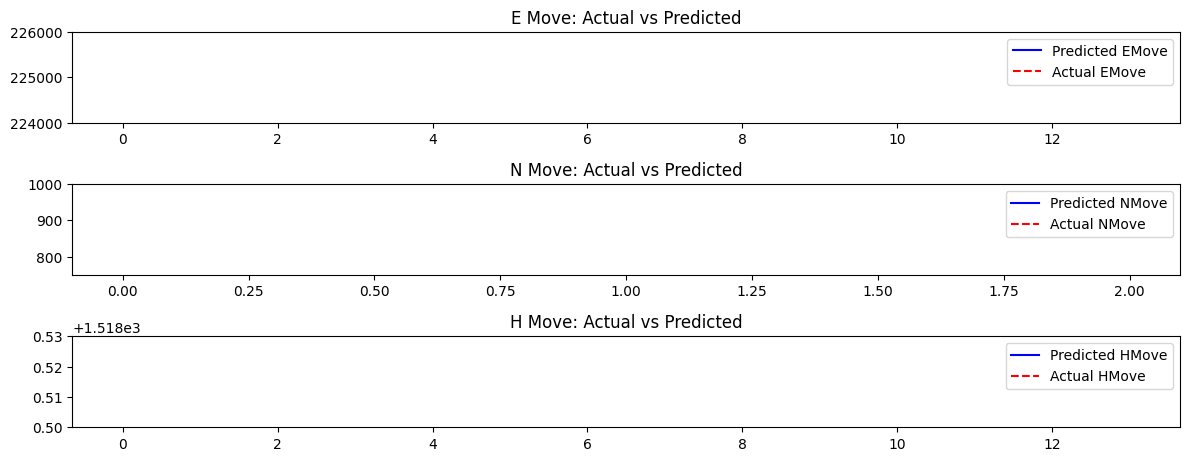

In [108]:
import matplotlib.pyplot as plt

# Find global min and max for y-axis across all movement components
y_min = 750  # You can adjust this to the actual min of your data
y_max = 1000  # You can adjust this to the actual max of your data

# Plot predictions vs actual values for each movement component
plt.figure(figsize=(12, 6))

# For EMove (target 0)
actuals_E = actuals[0,:].cpu().numpy()
predicted_E = predictions[0,:].cpu().numpy()
print(actuals_E,'\n',predicted_E)
plt.subplot(4, 1, 1)
plt.plot(predicted_E, label="Predicted EMove", color='blue')
plt.plot(actuals_E, label="Actual EMove", color='red', linestyle='dashed')
plt.title("E Move: Actual vs Predicted")
plt.ylim(224000,226000)  # Set same y-axis range
plt.legend()

# For NMove (target 1)
actuals_N = actuals[:, 1].cpu().numpy()
predicted_N = predictions[:, 1].cpu().numpy()
plt.subplot(4, 1, 2)
plt.plot(predicted_N, label="Predicted NMove", color='blue')
plt.plot(actuals_N, label="Actual NMove", color='red', linestyle='dashed')
plt.title("N Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

# For HMove (target 2)
actuals_H = actuals[2,:].cpu().numpy()
predicted_H = predictions[2,:].cpu().numpy()
plt.subplot(4, 1, 3)
plt.plot(predicted_H, label="Predicted HMove", color='blue')
plt.plot(actuals_H, label="Actual HMove", color='red', linestyle='dashed')
plt.title("H Move: Actual vs Predicted")
plt.ylim(1518.5,1518.53)  # Set same y-axis range
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_318767/3086205001.py:37: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


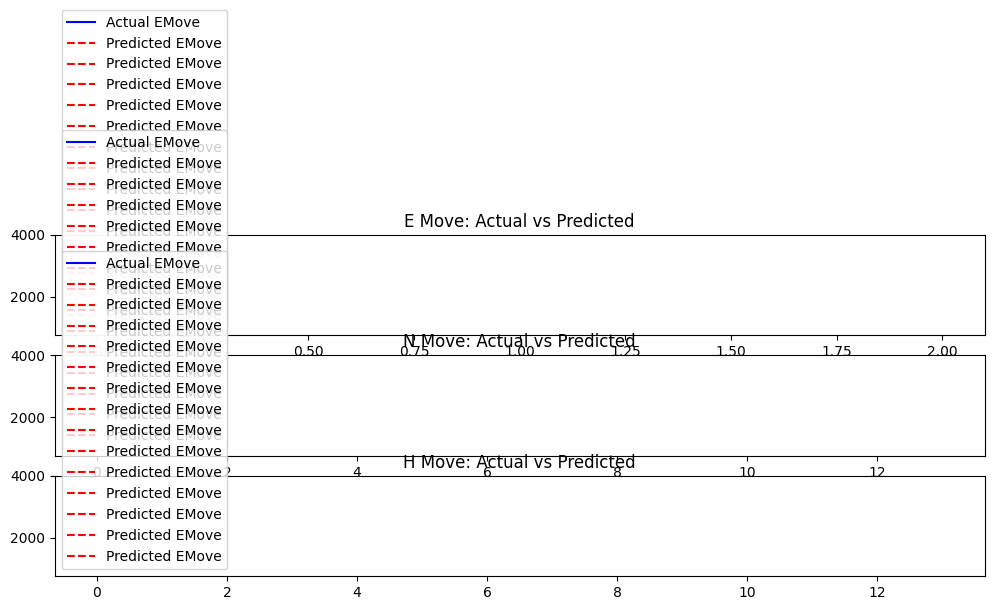

In [109]:
import matplotlib.pyplot as plt

# Find global min and max for y-axis across all movement components
y_min = 750#min(y_test_trues.min(), y_test_preds.min(), total_move_test_true.min(), total_move_test_pred.min())
y_max = 4000#max(y_test_trues.max(), y_test_preds.max(), total_move_test_true.max(), total_move_test_pred.max())

# Plot predictions vs actual values for  each movement component
plt.figure(figsize=(12, 6))

actuals[0, 0].cpu().numpy()
predicted_target = predictions[:,0].cpu().numpy()
plt.subplot(4, 1, 1)
plt.plot(predicted_target, label="Actual EMove", color='blue')
plt.plot(actuals, label="Predicted EMove", color='red', linestyle='dashed')
plt.title("E Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

actuals = torch.cat([y[1] for x,(y,weight) in iter(val_dataloader)])
predicted_target = predictions[1].cpu()
plt.subplot(4, 1, 2)
plt.plot(predicted_target, label="Actual EMove", color='blue')
plt.plot(actuals, label="Predicted EMove", color='red', linestyle='dashed')
plt.title("N Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

actuals = torch.cat([y[2] for x,(y,weight) in iter(val_dataloader)])
predicted_target = predictions[2].cpu()
plt.subplot(4, 1, 3)
plt.plot(predicted_target, label="Actual EMove", color='blue')
plt.plot(actuals, label="Predicted EMove", color='red', linestyle='dashed')
plt.title("H Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

plt.tight_layout()
plt.show()